In [ ]:
ids=df.measureid.unique()
for i in ids:
    df2=df[df['measureid']==i]
    print(i)
    print(df2[['createdat','performance_rate','measureid']])

In [1]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
from pymongo import MongoClient
from array import array
from heapq import nlargest
import warnings
import itertools
import statsmodels.api as sm



            performance_rate
createdat                   
2019-08-28               0.8
2019-08-30               0.8
2019-08-31               0.7
2019-09-01               0.6
2019-09-02               0.7
2019-09-03               0.5
2019-09-10               0.7
2019-09-16               0.8
2019-09-23               0.7
2019-09-30               0.5
2019-10-21               0.6
2019-10-22               0.7
2019-10-28               0.8
2019-11-04               0.7
2019-11-11               0.8
2019-11-18               0.6
2019-11-19               0.7
2019-11-20               0.6
2019-11-21               0.7
2019-11-22               0.6
2019-11-23               0.7
2019-11-24               0.6
2019-11-25               0.8


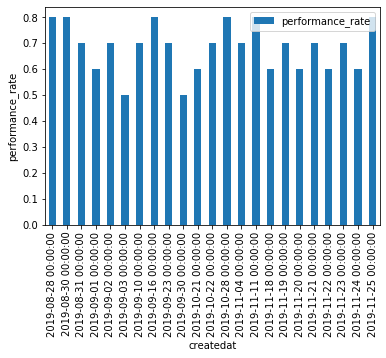

In [2]:


# Create pandas dataframe to store our X and y values
df = pd.read_json('D:\\prediction\\HC_Performance_rate.json')
#print(df.columns)
#df=df.dropna()
df = df[pd.notnull(df['performance_rate'])]
#df['createdat']=pd.to_datetime(df['createdat'],format="%Y-%m-%d")



df['createdat']=pd.to_datetime(df['createdat'])
df['createdat'] = df['createdat'].dt.normalize()
"""
df['createdat']=df['createdat'].to_string()

#df['createdat']=df['createdat'].fillna(df['createdat'].bfill())

"""

df.sort_values('createdat', inplace=True, ascending=True)

df.set_index(['createdat'], inplace=True)

#print(df)

df2=df[df['measureid']==12]
df3=df2.drop(columns=['measureid', 'threshold_value'])
print(df3)
# Plot the data
# checiking Frequncy in Year Wise 

df3.plot(kind='bar')
plt.ylabel('performance_rate')
plt.xlabel('createdat')
plt.show()


In [4]:
df3.describe()

,performance_rate
count,23.000000
mean,0.682609
std,0.093673
min,0.500000
25%,0.600000
50%,0.700000
75%,0.750000
max,0.800000


In [5]:
df3.isnull().sum()

performance_rate    0
dtype: int64

In [3]:

# Arima model intilation

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [4]:
# split the train and test and data 
train_data = df3['2019-08-28':'2019-11-19']
test_data = df3['2019-11-20':'2019-11-25']


In [5]:
train_data

,performance_rate
createdat,
2019-08-28,0.8
2019-08-30,0.8
2019-08-31,0.7
2019-09-01,0.6
2019-09-02,0.7
2019-09-03,0.5
2019-09-10,0.7
2019-09-16,0.8
2019-09-23,0.7


In [6]:
test_data

,performance_rate
createdat,
2019-11-20,0.6
2019-11-21,0.7
2019-11-22,0.6
2019-11-23,0.7
2019-11-24,0.6
2019-11-25,0.8


In [7]:
# applly the data model 

warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [8]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is -18.725302043877647 for model SARIMAX(0, 1, 1)x(0, 0, 0, 12)


In [9]:

# Let's fit this model

mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [10]:
# predict 2019 data 
pred0 = results.get_prediction(start='2019-11-19', dynamic=False)
pred0_ci = pred0.conf_int()

print(pred0.predicted_mean['2019-11-19':'2022-11-30' ])

createdat
2019-11-19    0.68
dtype: float64


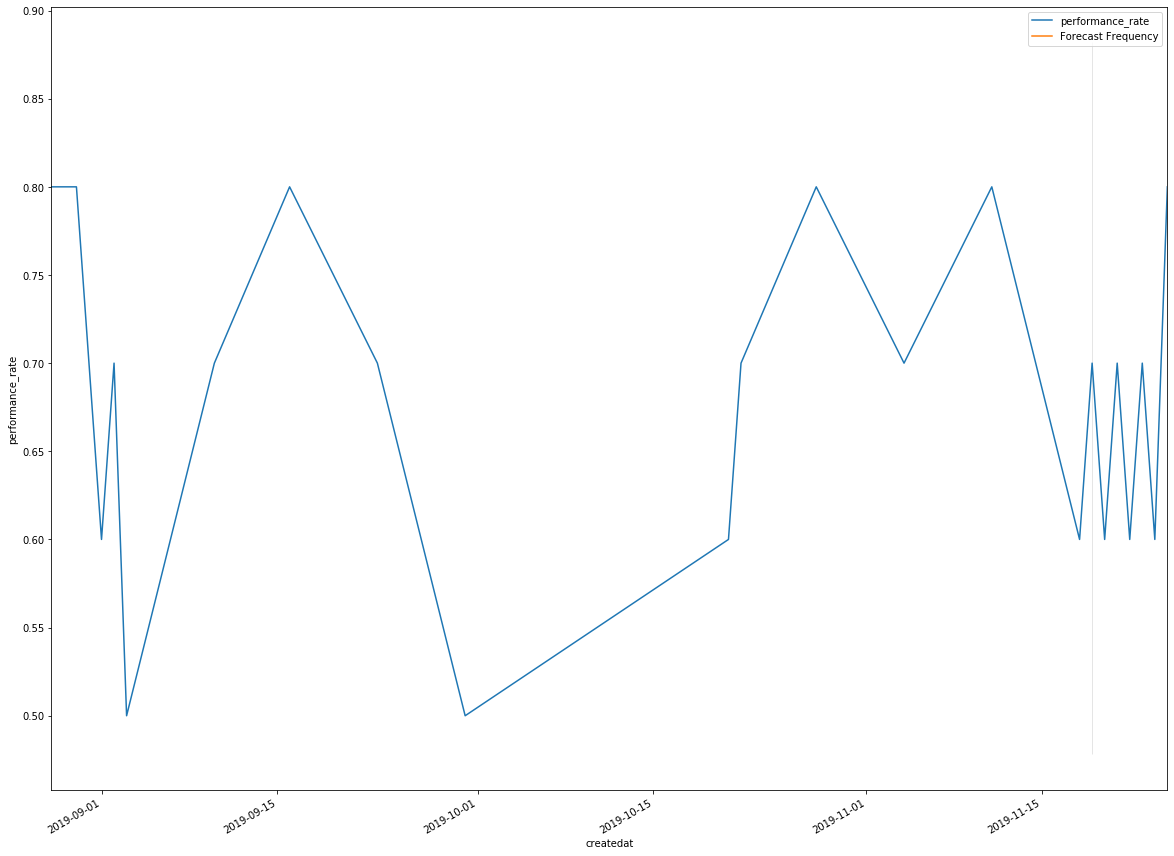

In [11]:
# predict the future prediction 2018- 2020


ax = df3['2019':'2022'].plot(figsize=(20, 16))

# pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
# pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')

pred0.predicted_mean.plot(ax=ax, label='Forecast Frequency')
ax.fill_between(pred0_ci.index, pred0_ci.iloc[:, 0], pred0_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('performance_rate')
plt.xlabel('createdat')
plt.legend()
plt.show()

In [18]:
#checking error Rate in Your Predection 

# this part is very importatnt part


prediction = pred0.predicted_mean['2019-11-01':].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2019 is {:.2f}%'.format(MAPE))

mse = ((prediction - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Absolute Percentage Error for the forecast of year 2019 is 10.12%
The Mean Squared Error of our forecasts is 0.01


In [16]:
#Producing and Visualizing Forecasts
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


In [17]:
ax = df3.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('createdat')
ax.set_ylabel('performance_rate')

plt.legend()
plt.show()

ValueError: year 0 is out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000177A4D1EBF8> (for post_execute):


ValueError: year 0 is out of range

ValueError: year 0 is out of range

In [1]:
#   https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
#   demo video for this example